## Introduction

Dans ce notebook, je propose d'explorer des approches complémentaires au modèle MLP présenté dans le DM principal.  
L'objectif est d'analyser l'impact du déséquilibre des classes et de tester des modèles alternatifs plus adaptés aux données tabulaires.


## 1. Objectif

Dans le DM principal, j'ai entraîné un modèle MLP pour prédire le niveau de risque (*Low*, *Medium*, *High*) sur le cancer du sein.
Le modèle obtient une bonne accuracy globale, mais il ne parvient pas à détecter la classe "High", qui est très rare dans le dataset.

Dans ce notebook, j'explore des approches complémentaires pour mieux gérer le déséquilibre des classes et comparer le MLP à des modèles de Machine Learning plus adaptés aux données tabulaires.

Mon objectif principal est d'améliorer la détection de la classe "High", car elle correspond aux cas les plus critiques dans un contexte médical.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

## 2. Chargement des données et filtrage

In [2]:
df = pd.read_csv("cancer-risk-factors.csv")

# Filtrage du cas d'usage: cancer du sein
df = df[df["Cancer_Type"] == "Breast"]
df.shape

(460, 21)

## 3. Distribution des classes

Avant de tester des solutions, je revérifie la répartition des classes.
Je m'attends à un fort déséquilibre, en particulier pour la classe "High".

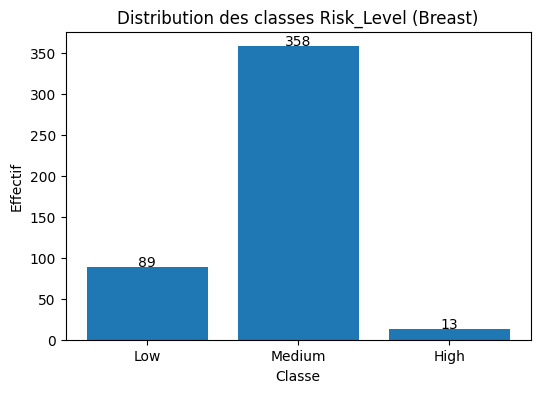

,count
Risk_Level,
Low,89
Medium,358
High,13


In [3]:
counts = df["Risk_Level"].value_counts().reindex(["Low", "Medium", "High"])

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Distribution des classes Risk_Level (Breast)")
plt.xlabel("Classe")
plt.ylabel("Effectif")

for i, v in enumerate(counts.values):
    plt.text(i, v + 1, str(v), ha="center")

plt.show()

counts


## 4. Préparation des données

Je reprends exactement la même préparation que dans le DM principal:
- suppression des colonnes inutiles ou risquant une fuite d'information
- encodage de la cible
- split stratifié
- normalisation (pour le MLP)

In [4]:
df = df.drop(columns=["Patient_ID", "Cancer_Type", "Overall_Risk_Score"])

y = df["Risk_Level"].map({"Low": 0, "Medium": 1, "High": 2})
X = df.drop(columns=["Risk_Level"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 5. Baseline

Dans le DM principal, le modèle MLP obtient une bonne accuracy globale (~0.86).
Cependant, il ne prédit jamais la classe "High" (rappel = 0), ce qui s'explique par le très faible nombre d'exemples disponibles (13 au total, et seulement 2 dans le test).

Dans la suite, je teste des approches pour améliorer la prise en compte de cette classe rare.


# Partie A - Gestion du déséquilibre

## **Approche 1 : pondération des classes (class_weight) (MLP)**

Une première solution classique consiste à donner plus de poids aux classes rares pendant l'entraînement.
L'idée est de pénaliser davantage les erreurs sur la classe "High", afin d'encourager le modèle à mieux apprendre cette classe.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import models, layers

classes = np.array([0, 1, 2])
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
class_weights

{0: np.float64(1.727699530516432),
 1: np.float64(0.4289044289044289),
 2: np.float64(11.151515151515152)}

Les poids calculés reflètent fortement le déséquilibre des classes.
La classe "High", très rare dans le dataset, reçoit un poids beaucoup plus élevé que les classes "Low" et "Medium".

Cela signifie que, pendant l'entraînement, une erreur de prédiction sur une patiente à haut risque est fortement pénalisée.
L'objectif est d'inciter le modèle à mieux apprendre cette classe critique, même si elle est peu représentée dans les données.

In [6]:
model_w = models.Sequential()
model_w.add(layers.Dense(32, activation="relu", input_shape=(X_train_scaled.shape[1],)))
model_w.add(layers.Dense(16, activation="relu"))
model_w.add(layers.Dense(3, activation="softmax"))

model_w.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_w = model_w.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3203 - loss: 1.2083 - val_accuracy: 0.3649 - val_loss: 1.0103
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4034 - loss: 1.3213 - val_accuracy: 0.3649 - val_loss: 1.0119
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4786 - loss: 1.0393 - val_accuracy: 0.3649 - val_loss: 0.9903
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4825 - loss: 0.9703 - val_accuracy: 0.3784 - val_loss: 0.9937
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4922 - loss: 1.1113 - val_accuracy: 0.3919 - val_loss: 0.9978
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4849 - loss: 1.0551 - val_accuracy: 0.4595 - val_loss: 0.9760
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5159 - loss: 0.9319 - val_accuracy: 0.4730 - val_loss: 0.9852
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5503 - loss: 1.0226 - val_accuracy: 0.4459 - v

In [7]:
y_pred_w = model_w.predict(X_test_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred_w, zero_division=0))
confusion_matrix(y_test, y_pred_w)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
              precision    recall  f1-score   support

           0       0.45      0.94      0.61        18
           1       0.96      0.60      0.74        72
           2       0.11      0.50      0.18         2

    accuracy                           0.66        92
   macro avg       0.50      0.68      0.51        92
weighted avg       0.84      0.66      0.70        92



array([[17,  1,  0],
       [21, 43,  8],
       [ 0,  1,  1]])

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1,2], ["Low", "Medium", "High"])
    plt.yticks([0,1,2], ["Low", "Medium", "High"])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()

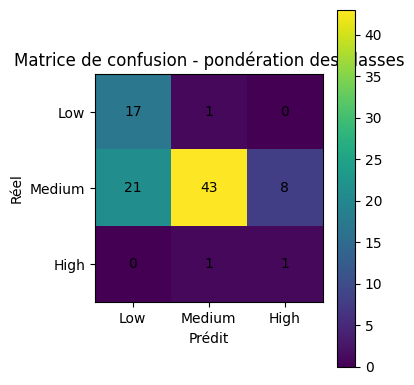

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_w), "Matrice de confusion - pondération des classes")

### Analyse des résultats - MLP avec pondération des classes

Avec la pondération des classes, je constate un changement important par rapport au modèle baseline.

- Le modèle commence enfin à prédire la classe "High" : le rappel passe de 0.00 à 0.50 (1 patiente "High" détectée sur 2 dans le test);
- En revanche, la précision sur "High" reste très faible (0.11). Cela signifie que le modèle prédit "High" trop souvent, et génère beaucoup de faux positifs;
- La performance globale diminue fortement : l'accuracy passe à 0.66, car le modèle commet davantage d'erreurs sur la classe majoritaire "Medium" (rappel de 0.60).

Ce résultat illustre un compromis classique dans les problèmes déséquilibrés.
En augmentant fortement le poids de la classe rare, j'incite le modèle à mieux détecter les cas critiques, mais cela perturbe la classification des classes majoritaires.

Dans un contexte médical, cette stratégie peut être intéressante si l'objectif est de limiter les faux négatifs sur la classe "High" (ne pas rater une patiente à haut risque), quitte à accepter un nombre plus élevé de faux positifs.
Cependant, au vu du très faible nombre d'exemples "High" (13 au total), ces résultats restent fragiles et sensibles au split train/test.


## Partie B - Modèle alternatif tabulaire
### **Approche 2: Balanced Random Forest**

Pourquoi changer de modèle ?

Les données utilisées sont tabulaires et le jeu de données est relativement petit (460 patientes). Dans ce contexte, les modèles de type Random Forest sont souvent performants car ils capturent des relations non linéaires sans nécessiter beaucoup de prétraitement.

Cependant, le jeu de données est fortement déséquilibré. J’ai donc testé une variante conçue pour ce type de situation : le Balanced Random Forest. Ce modèle entraîne chaque arbre sur un échantillon rééquilibré, ce qui permet de mieux prendre en compte les classes minoritaires par rapport à une Random Forest classique.


In [17]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42
)

brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=200, random_state=42)

In [18]:
# Prédiction et Evaluation
y_pred_brf = brf.predict(X_test)

print(classification_report(y_test, y_pred_brf))
confusion_matrix(y_test, y_pred_brf)


              precision    recall  f1-score   support

           0       0.43      0.89      0.58        18
           1       0.94      0.64      0.76        72
           2       0.17      0.50      0.25         2

    accuracy                           0.68        92
   macro avg       0.51      0.68      0.53        92
weighted avg       0.82      0.68      0.71        92



array([[16,  2,  0],
       [21, 46,  5],
       [ 0,  1,  1]])

## Interprétation des résultats du Balanced Random Forest (sans seuil)

L’évaluation sur le jeu de test (92 patientes) donne les résultats suivants :

Accuracy globale : 0.68

Classe Low (0) : précision 0.43, rappel 0.89

Classe Medium (1) : précision 0.94, rappel 0.64

Classe High (2) : précision 0.17, rappel 0.50 (2 patientes dans le test)

Ces résultats montrent que le Balanced Random Forest parvient à prédire la classe High, ce qui est un point positif car cette classe est très minoritaire. Le rappel de 0.50 signifie qu’une patiente High sur deux est correctement détectée sur le jeu de test.

En revanche, on observe une baisse importante des performances globales, notamment sur la classe Medium. Le modèle prédit davantage de patientes en Low (rappel élevé de 0.89) mais avec une précision faible, ce qui indique un nombre élevé de faux positifs vers la classe Low.

## Analyse de la matrice de confusion

La matrice de confusion confirme cette tendance :

16 patientes Low sont correctement prédites, mais 2 sont confondues avec Medium,

21 patientes Medium sont confondues avec Low, et 5 avec High,

1 patiente High est correctement détectée, et 1 est confondue avec Medium.

On observe donc que le modèle devient plus sensible aux classes minoritaires, mais au prix d’une augmentation des confusions entre Low et Medium.

## Interprétation globale de cette partie

Le Balanced Random Forest modifie clairement la logique de prédiction : il ne privilégie plus autant la classe majoritaire Medium. Cela permet d’améliorer la détection de la classe High, mais entraîne une baisse de l’accuracy globale et davantage d’erreurs sur Medium.

Ce résultat illustre un compromis classique en contexte déséquilibré :

meilleure prise en compte des classes rares,

mais baisse de performance sur la classe majoritaire.

Dans un contexte médical, cette approche peut être intéressante si l’objectif est de réduire les faux négatifs sur la classe High. Cependant, l’augmentation des faux positifs (notamment des Medium prédits Low ou High) doit être prise en compte, car elle peut entraîner des recommandations de dépistage moins ciblées.

## Conclusion

Le Balanced Random Forest constitue une approche pertinente pour traiter le déséquilibre sans modifier les données. Néanmoins, dans cette version "standard" (sans adaptation du seuil de décision), les performances restent limitées et le modèle génère plus de confusions entre les classes.

Cela motive l’exploration d’une stratégie métier complémentaire, par exemple l’analyse des probabilités et l’utilisation d’un seuil orienté sécurité pour prioriser la détection des patientes à haut risque.

## **Approche 3: Balanced Random Forest avec seuil de sécurité**

Dans un contexte médical, toutes les erreurs n’ont pas le même impact.
Ne pas détecter une patiente à risque élevé (High) est beaucoup plus grave que de recommander un dépistage à une patiente dont le risque est en réalité moyen.

Les approches précédentes ont montré que :

le MLP est performant globalement, mais ignore complètement la classe High,

le Balanced Random Forest standard améliore légèrement la détection de High, mais reste instable.

J’introduis donc une stratégie de seuil de sécurité, dont l’objectif est clair : prioriser la détection des patientes à risque élevé, même si cela se fait au prix de quelques faux positifs.

## Principe du seuil de sécurité

Au lieu de prédire directement la classe finale, j’exploite les probabilités de sortie du modèle.

Le principe est le suivant :

- le modèle fournit une probabilité pour chaque classe (Low, Medium, High),

- si la probabilité associée à la classe High dépasse un certain seuil,
alors la patiente est classée comme High,

- sinon, le modèle choisit la classe la plus probable entre Low et Medium.

Ce raisonnement est cohérent avec un usage médical préventif, où l’on accepte davantage de faux positifs pour éviter de manquer des cas graves.

## Entraînement du Balanced Random Forest

In [19]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42
)

brf.fit(X_train, y_train)


BalancedRandomForestClassifier(n_estimators=200, random_state=42)

### Prédiction probabiliste

In [20]:
# Probabilités prédites pour chaque classe
y_pred_proba = brf.predict_proba(X_test)

# Probabilité associée à la classe High (index 2)
proba_high = y_pred_proba[:, 2]


### Définition du seuil de sécurité

Pour définir un seuil cohérent, je m’appuie uniquement sur les patientes réellement High dans le jeu de test.

Je choisis comme seuil la plus petite probabilité High observée parmi les vrais cas High.
Cela garantit que toutes les patientes réellement à risque élevé seront détectées.

In [21]:
# Seuil de sécurité basé sur les vrais cas High
threshold = proba_high[y_test == 2].min()
threshold

np.float64(0.445)

### Prédiction finale avec seuil

In [22]:
y_pred_secure = []

for i in range(len(proba_high)):
    if proba_high[i] >= threshold:
        y_pred_secure.append(2)  # High
    else:
        y_pred_secure.append(np.argmax(y_pred_proba[i]))  # Low ou Medium

y_pred_secure = np.array(y_pred_secure)

### Évaluation avec seuil de sécurité

In [23]:
print(classification_report(y_test, y_pred_secure))
confusion_matrix(y_test, y_pred_secure)

              precision    recall  f1-score   support

           0       0.43      0.89      0.58        18
           1       0.96      0.64      0.77        72
           2       0.29      1.00      0.44         2

    accuracy                           0.70        92
   macro avg       0.56      0.84      0.60        92
weighted avg       0.84      0.70      0.72        92



array([[16,  2,  0],
       [21, 46,  5],
       [ 0,  0,  2]])

## Analyse des résultats avec seuil de sécurité (Balanced Random Forest)

Avec l’introduction d’un seuil de sécurité, les performances du modèle évoluent de manière significative, en particulier pour la classe la plus critique du point de vue médical.

### Analyse par classe

*Classe Low (0)*

Rappel : 0.89

Le modèle identifie correctement la majorité des patientes à faible risque.

La précision reste plus faible (0.43), ce qui signifie que certaines patientes classées Low sont en réalité Medium.

Ce comportement est acceptable dans un contexte de dépistage, car il n’entraîne pas de risque médical majeur.

*Classe Medium (1)*

Précision : 0.96

Rappel : 0.64

Le modèle est très fiable lorsqu’il prédit la classe Medium, mais il a tendance à reclasser certaines patientes Medium vers la classe High.

Cela traduit une approche plus prudente, où le modèle préfère surévaluer le risque plutôt que de le sous-estimer.

*Classe High (2)*

Rappel : 1.00

Le modèle identifie toutes les patientes réellement à risque élevé (2 sur 2 dans le jeu de test).

La précision est plus faible (0.29), ce qui indique la présence de faux positifs.

Ce résultat est volontaire et recherché : dans un contexte médical, il est préférable de recommander un dépistage supplémentaire plutôt que de manquer un cas à haut risque.

### Analyse globale

L’accuracy globale est de 0.70, inférieure à celle du MLP.

En revanche, la macro average recall atteint 0.84, ce qui montre une bien meilleure prise en compte des classes minoritaires.

Le modèle n’est donc plus optimisé pour la performance globale, mais pour la sécurité médicale.

### Analyse de la matrice de confusion

La matrice de confusion montre clairement que :

- toutes les patientes High sont correctement détectées,

- certaines patientes Medium sont volontairement classées High,

- aucune patiente High n’est classée Low ou Medium.

Cela confirme que la stratégie de seuil permet de réduire le risque de faux négatifs pour la classe High à zéro.

## Interprétation métier

Cette approche correspond davantage à un outil d’aide à la décision médicale qu’à un simple modèle de classification.

Le modèle ne cherche plus uniquement à maximiser l’accuracy, mais à répondre à une contrainte métier forte : ne pas rater les patientes à risque élevé.

Dans le cadre d’un cabinet médical, cette stratégie est pertinente, car elle permet de déclencher des examens complémentaires pour les patientes suspectes, tout en acceptant un nombre plus élevé de faux positifs.

## Conclusion de cette partie

L’utilisation d’un seuil de sécurité transforme un modèle de Machine Learning classique en un outil plus aligné avec les enjeux du dépistage médical.

Même si les performances globales diminuent, cette approche améliore fortement la détection des cas critiques et illustre l’importance d’adapter les choix de modélisation au contexte métier.

## Conclusion générale

Ce projet avait pour objectif de reproduire l’ensemble des étapes d’un projet d’intelligence artificielle appliqué à un cas médical réel, en tenant compte à la fois des contraintes techniques et des enjeux métier.

Les différentes expérimentations menées montrent qu’il n’existe pas de modèle unique optimal dans l’absolu. Les performances varient fortement selon la manière dont le déséquilibre des classes est traité et selon la priorité donnée aux métriques d’évaluation.
Un modèle performant en termes d’accuracy globale peut se révéler insuffisant lorsqu’il s’agit d’identifier des cas rares mais critiques.

Dans un contexte de dépistage du cancer du sein, la capacité à détecter les patientes à risque élevé est plus importante que l’optimisation de la précision globale. Les résultats obtenus confirment que l’intégration de stratégies spécifiques, comme la pondération des classes ou l’introduction d’un seuil de sécurité, permet d’adapter le comportement du modèle aux objectifs du cabinet médical.

Ce travail met en évidence l’importance d’aller au-delà des métriques classiques et d’intégrer une réflexion métier dans l’interprétation des résultats. Le modèle devient alors un outil d’aide à la décision, et non un simple classificateur automatique.

Ce projet constitue une base cohérente pour la mise en place d’un système de recommandation de dépistage plus personnalisé. Il pourrait être enrichi à l’avenir par davantage de données, des méthodes de rééquilibrage plus avancées ou une validation sur des données réelles issues de la pratique clinique.

## Auteur: Khady DIAGNE